In [ ]:
!wget 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'

--2021-07-24 17:18:34--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz’

BSDS300-images.tgz  100%[===================>]  21.18M  3.25MB/s    in 5.3s    

2021-07-24 17:18:39 (3.98 MB/s) - ‘BSDS300-images.tgz’ saved [22211847/22211847]



In [30]:
from os import listdir
from os.path import join

import torch.utils.data as data
from PIL import Image

import cv2
import numpy as np

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input_image = load_img(self.image_filenames[index])
        target = input_image.copy()
        if self.input_transform:
            input_image = self.input_transform(input_image)
        if self.target_transform:
            target = self.target_transform(target)

        return input_image, target

    def __len__(self):
        return len(self.image_filenames)

In [ ]:
import tarfile
from os import remove
from os.path import exists, join, basename

from six.moves import urllib
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


def download_bsd300(dest="/content/dataset/"):
    output_image_dir = join(dest, "BSDS300/images")   
    print("Extracting data")
    with tarfile.open('/content/BSDS300-images.tgz') as tar:
      for item in tar:
          tar.extract(item, '/content/dataset')

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

In [5]:
import torch
import torch.nn as nn


class Net(torch.nn.Module):
    def __init__(self, num_channels, upscale_factor, d=64, s=12, m=4):
        super(Net, self).__init__()

        self.first_part = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=d, kernel_size=5, stride=1, padding=2),
                                        nn.PReLU())

        self.layers = []
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        for _ in range(m):
            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.PReLU())
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))

        self.mid_part = torch.nn.Sequential(*self.layers)

        # Deconvolution
        self.last_part = nn.ConvTranspose2d(in_channels=d, out_channels=num_channels, kernel_size=9, stride=upscale_factor, padding=3, output_padding=1)

    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out

    def weight_init(self, mean=0.0, std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.0001)
                if m.bias is not None:
                    m.bias.data.zero_()


In [6]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

In [43]:
from __future__ import print_function
from math import log10

import torch
import torch.backends.cudnn as cudnn

class FSRCNNTrainer(object):
    def __init__(self,  training_loader, testing_loader):
        super(FSRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = 0.00003
        self.nEpochs = 25
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = 123
        self.upscale_factor = 4
        self.training_loader = training_loader
        self.testing_loader = testing_loader

    def build_model(self):
        self.model = Net(num_channels=1, upscale_factor=self.upscale_factor).to(self.device)
        self.model.weight_init(mean=0.0, std=0.2)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)  # lr decay

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        for batch_num, (data, target) in enumerate(self.training_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(data), target)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))

    def test(self):
        self.model.eval()
        avg_psnr = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                psnr = 10 * log10(1 / mse.item())
                avg_psnr += psnr
                progress_bar(batch_num, len(self.testing_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

        print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))

    def run(self):
        self.build_model()
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            if epoch == self.nEpochs:
                self.save_model()

In [44]:
from __future__ import print_function
from torch.utils.data import DataLoader

# ===========================================================
# Set train dataset & test dataset
# ===========================================================
print('===> Loading datasets')
train_set = get_training_set(4)
test_set = get_test_set(4)


training_data_loader = DataLoader(dataset=train_set,batch_size=32 , shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, batch_size=1 ,shuffle=False)


model = FSRCNNTrainer(training_data_loader, testing_data_loader)
model.run()

===> Loading datasets
Extracting data
Extracting data

===> Epoch 1 starts:
 7/7 [================================================================================>]  Step: 59ms | Tot: 944ms | Loss: 0.1696
    Average Loss: 0.1696
 100/100 [================================================================================>]  Step: 18ms | Tot: 2s41ms | PSNR: 11.1657
    Average PSNR: 11.1657 dB

===> Epoch 2 starts:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 7/7 [================================================================================>]  Step: 60ms | Tot: 937ms | Loss: 0.0497
    Average Loss: 0.0497
 100/100 [================================================================================>]  Step: 21ms | Tot: 2s49ms | PSNR: 15.7902
    Average PSNR: 15.7902 dB

===> Epoch 3 starts:
 7/7 [================================================================================>]  Step: 57ms | Tot: 944ms | Loss: 0.0279
    Average Loss: 0.0279
 100/100 [================================================================================>]  Step: 18ms | Tot: 2s12ms | PSNR: 15.6807
    Average PSNR: 15.6807 dB

===> Epoch 4 starts:
 7/7 [================================================================================>]  Step: 58ms | Tot: 935ms | Loss: 0.0264
    Average Loss: 0.0264
 100/100 [================================================================================>]  Step: 13ms | Tot: 2s31ms | PSNR: 16.5181
    Average PSNR: 16.5181 dB

=

In [45]:
def load_model(model_path):

    GPU_IN_USE = torch.cuda.is_available()
    device = torch.device('cuda' if GPU_IN_USE else 'cpu')
    model=torch.load(test_model_path, map_location='cpu')
    model = model.to(device)
    return ( model , device )

# output high resolution image to output_dir, with the current model
def creat_image(device , input_dir,output_dir):
    GPU_IN_USE = torch.cuda.is_available()
   
    start = time.time()
    
    img = Image.open(input_dir).convert('YCbCr')
    y, cb, cr = img.split()
    

  #  model = torch.load(input_model, map_location=lambda storage, loc: storage)
  #  model = model.to(device)
    data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    data = data.to(device)

    if GPU_IN_USE:
        cudnn.benchmark = True
        #print('lalallalala')
    out = model(data)
    out = out.cpu()
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

    out_img.save(output_dir)
    
    end = time.time()
    elapsed = end - start
    
    print('output image saved to:', output_dir,'   running time:',elapsed,'s')


In [59]:
import matplotlib.pyplot as plt

test_model_path='/content/model_path.pth'

test_img='/content/low-res.png'
original_img='/content/new_flower_test (1).png'
output_img='/content/output.png'

model , device =load_model(test_model_path)

creat_image(device ,input_dir=test_img , output_dir=output_img)

original_img = cv2.imread(original_img)
test_img = cv2.imread(test_img)

output_img = cv2.imread(output_img)
output_img = cv2.resize (output_img , (282,280)) 

cv2.imwrite('output_resized_img.jpg', output_img)
output_img = cv2.imread('output_resized_img.jpg')

new_ssim= ssim(original_img,output_img,multichannel=True)
new_psnr = psnr(original_img,output_img)


output image saved to: /content/output.png    running time: 0.6740295886993408 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


In [60]:
print('\n Orignal Vs FSRCNN with batchsize 64: \n PSNR: %f , \n SSIM: %f \n\n' %(new_psnr,new_ssim*100))


 Orignal Vs FSRCNN with batchsize 64: 
 PSNR: 21.154891 , 
 SSIM: 75.765760 




Text(0.5, 1.0, 'FSRCNN')

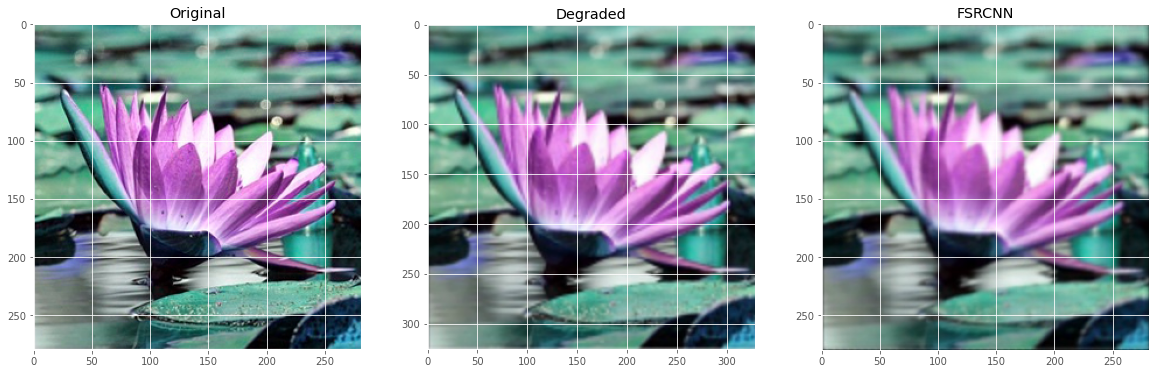

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(original_img)
axs[0].set_title('Original')
axs[1].imshow(test_img)
axs[1].set_title('Degraded')
axs[2].imshow(output_img)
axs[2].set_title('FSRCNN')